In [1]:
import sdeint
import numpy as np
#import random as rand
import matplotlib.pyplot as plt
#from itertools import accumulate
from scipy.optimize import curve_fit
from synthetic_env_julia_solver import synthetic_env
from naive_agents import DoNothing, FixedPhi
#from scipy.stats import norm

## First run Numerics Outside of Environment

In [5]:
def expected_prop_2d(r,PHI,D,r_d,scaling=1.0):
    return scaling*np.power((r_d/r),(2*(PHI-D)/D))/r

def f(u, t):
    #print(u)
    return np.array([
        u[2]*u[0] + u[3]*u[1] - PHI * u[0],
        u[4]*u[0] + u[5]*u[1] - PHI * u[1],
        -u[2],
        -u[3],
        -u[4],
        -u[5]
    ])

def g(u, t):
    return np.array([
        [np.sqrt(kappa), 0, 0, 0, 0],
        [0, np.sqrt(kappa), 0, 0, 0],
        [0, 0, np.sqrt(D), 0, 0],
        [0, 0, 0, np.sqrt(D), np.sqrt(2) * np.sqrt(D)],
        [0, 0, 0, np.sqrt(D), -np.sqrt(2) * np.sqrt(D)],
        [0, 0, -np.sqrt(D), 0, 0]
    ])

In [2]:
# Choose Params
BETA = 0.1
kappa = 0.001
D = 0.1
nu = 0.99
dim=2
D_tilde = D*(dim+1)*(dim-1)
PHI = (D_tilde + np.sqrt(4*BETA+D_tilde))/2
r_d = np.sqrt(kappa/D)


#Params that are close to ABC flow params

#PHI = 0.7  
#kappa = 0.02*np.pi
#D = 0.25
#r_d = np.sqrt(kappa/D)
print(PHI)
print(r_d)

0.5683300132670378
0.1


In [7]:
# Run the SDEs 
u0 = np.zeros(6)
tspan = np.arange(0.0, 10000.0,0.005)  # 10000 time units

result = sdeint.itoint(f, g, u0, tspan)

separations = np.sum(result[:, :2]**2, axis=1)
separations = np.sqrt(separations)


(1e-07, 100)

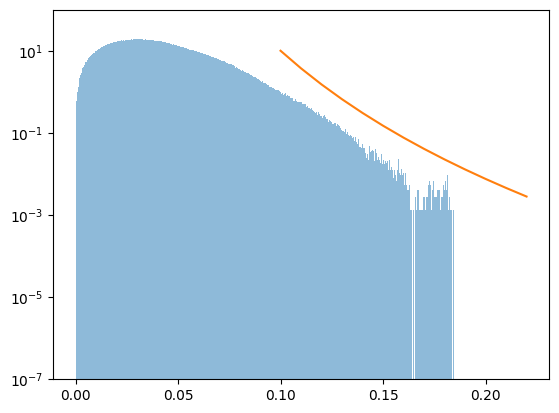

In [8]:
# Plot observed distribution don't plot early values before the distribution has settled into the stationary distribution
n,bins,_ = plt.hist(separations[1000:], bins=500, density=True, alpha=0.5)
x_points = np.arange(r_d,1.2*max(separations[1000:]),0.01)
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))
plt.yscale("log")
plt.ylim(bottom=10**(-7),top=10**(2))

In [12]:
expected_prop_2d(x_points,PHI,D,r_d)

array([10.])

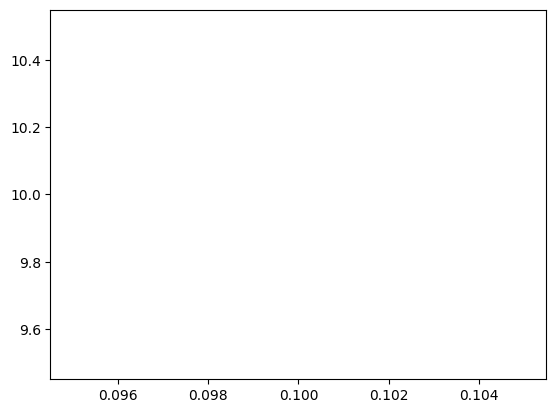

In [9]:
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))

## Now run within the environment to check that results are similiar 

In [3]:
# run environment with same parameters as above this is a good bit slower than just the bare bone numerics
fixed_agent = FixedPhi(PHI)
env = synthetic_env(r_d, beta=BETA, D=D,kappa=kappa, nu=nu)
env.deltaT= 0.005
env.limit = 10000
observed_distances = []
while not env.isOver():
    action = fixed_agent.sample_action(env.getState())
    reward = env.step(action)
    observed_distances.append(env.dist())

(1e-07, 100)

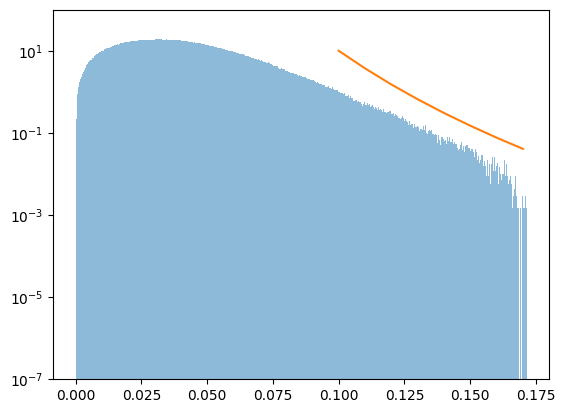

In [6]:
n,bins,_ = plt.hist(observed_distances, bins=500, density=True, alpha=0.5)
x_points = np.arange(r_d,max(observed_distances[1000:]),0.01)
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))
plt.yscale("log")
plt.ylim(bottom=10**(-7),top=10**(2))